In [1]:
import sys
import re
import datetime
from math import log
import csv
import pprint
import math
import random
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pandas as pd
from elasticsearch import Elasticsearch, helpers

from __future__ import division

%matplotlib inline

np.set_printoptions(threshold=100)
pd.set_option('display.max_rows', 100)

pp = pprint.PrettyPrinter()

In [2]:
es = Elasticsearch([{'host': 'hcc-metrics.unl.edu', 'port': 9200}])
username = 'cms'
password = 'B3A96-D0g_PkkPz5'
#es = Elasticsearch([{'host': 'es-cms.cern.ch', 'port': 9203, 'http_auth': username+':'+password}], use_ssl=True,verify_certs=True,ca_certs="ca-bundle.trust.crt")

In [3]:
indices = es.cat.indices(index="cms-*", h="index", request_timeout=600).split('\n')
indices = sorted(indices)
indices = [x for x in indices if x != '']

In [4]:
def time_filter(indices, days=0, until=0):
    if days == 0:
        return ["cms-*"]
    today = datetime.date.today()
    filtered = []
    datefmt = '%Y-%m-%d'
    for i in indices:
        day = re.sub(r'cms-', '', i).rstrip()
        day = datetime.datetime.strptime(day, datefmt).date()
        diff = today - day
        if until <= diff.days < days + until:
            filtered.append(i.rstrip())
    return filtered

In [85]:
# Change second argument to use a different time range for ES queries
ind = time_filter(indices, 30, 210)
ind = ','.join(ind)

In [86]:
def tasktype2(row):
    task = row['task'].lower()
    ttype = row['tasktype'].lower()

    if ttype == 'analysis':
        tt = 'Analysis'
    elif 'cleanupunmerged' in ttype:
        tt = 'Cleanup'
    elif 'logcollect' in ttype:
        tt = 'LogCollect'
    elif ttype == 'repack':
        tt = 'Repack'
    elif ttype.startswith('skim'):
        tt = 'Skim'
    elif 'harvest' in ttype:
        tt = 'Harvesting'
    elif 'merge' in ttype:
        tt = 'Merge'
    elif ttype.startswith('express'):
        tt = 'Express'
    elif ttype == 'alcaskim':
        tt = 'Alcaskim'
    elif 'gensim' in ttype:
        tt = 'GENSIM'
    elif ttype == 'montecarlofromgen':
        tt = 'GENSIM'
    elif ttype == 'gen':
        tt = 'GEN'
    elif ttype == 'reco':
        tt = 'RECO'
    elif ttype == 'dataprocessing':
        tt = 'RECO'
    elif ttype.startswith("reco"):
        tt = 'DIGI'
    elif ttype.endswith("_0"):
        tt = 'DIGI'
    elif ttype.endswith("_1"):
        tt = 'DIGIRECO'
    elif ttype.startswith("digi"):
        tt = 'DIGI'
    elif ttype == 'steponeproc':
        tt = 'DIGI'
    elif ttype == 'steptwoproc':
        tt = 'DIGIRECO'
    elif ttype == 'stepthreeproc':
        tt = 'DIGIRECOMINIAOD'
    elif 'miniaod' in ttype:
        tt = 'MINIAOD'
    elif ttype == 'production':
        tt = 'GENSIM'
    elif 'hlt' in ttype:
        tt = 'RECO'
    elif "validation" in task:
        tt = "Validation"
    elif "relval" in task:
        tt = "RelVal"
    elif "fastsim" in task:
        tt = "FastSim"
    elif "premix" in task:
        tt = "Premix"
    elif "minbias" in task:
        tt = "MinBias"
    else:
        tt = "Other"

    return tt

These variables are used:
* **RequestCpus**: number of cores used by the job
* **CpuTimeHr**: CPU time used by the job (hours)
* **WallClockHr**: wall-clock time used by the job (hours)
* **CoreHr**: wall-clock time used by the job times the number of cores (hours)
* **CpuEff**: CPU efficiency (%)
* **Type**: type of job (production or analysis)
* **Status**: job status (completed, running, idle, removed, held)
* **TaskType**: task type (analysis, production, merge, digireco, repack, reco, cleanup, logcollect, miniaod, express, dataprocessing, gensim, etc.)
* **Site**: site assigned to the job
* **Workflow**: workflow name
* **Kevents**: thousands of events in the job (often not reported by all versions of CMSSW)
* **InputGB**: amount of data read by job (GB)
* **OutputGB**: amount of data written by job (GB)

In [87]:
s1 = {
    "size": 0,
    "query": {
        "filtered": {
            "filter": {
                "bool": {
                    "filter": [
                        {
                            "range": {
                                "CpuTimeHr": {"gt": 0.}
                            }
                        },
                        {
                            "range": {
                                "CoreHr": {"gt": 0.}
                            }
                        },
                        { 
                            "exists": {
                                "field": "KEvents"
                            }
                        },
                        { 
                            "exists": {
                                "field": "InputGB"
                            }
                        },
                        {
                            "match": {
                                "Status": "completed"
                            }
                        }
                    ]
                }
            }
        }
    },
    "aggs": {
        "ttypes": {
            "terms": {
                "field": "TaskType",
                "size": 1000
            },
            "aggs": {
                "site": {
                    "terms": {
                        "field": "Site",
                        "size": 1000
                    },
                    "aggs": {
                        "wf": {
                            "terms": {
                                "field": "WMAgent_SubTaskName",   # unfortunately this excludes all analysis jobs
                                "size": 100000
                            },
                            "aggs": {
                                "type": {
                                    "terms": {
                                        "field": "Type",
                                        "size": 10
                                    },
                                    "aggs": {
                                        "1": {
                                            "extended_stats": {
                                                "script": "doc['KEvents'].value > 0 ? doc['CpuTimeHr'].value / doc['KEvents'].value * 3.6 : 0",
                                                "lang": "expression"
                                            }
                                        },
                                        "2": {
                                            "extended_stats": {
                                                "script": "doc['KEvents'].value > 0 ? doc['CoreHr'].value / doc['KEvents'].value * 3.6 : 0",
                                                "lang": "expression"
                                            }
                                        },
                                        "3": {
                                            "stats": {
                                                "field": "CpuTimeHr"
                                            }
                                        },
                                        "4": {
                                            "stats": {
                                                "field": "CoreHr"
                                            }
                                        },
                                        "6": {
                                            "avg": {
                                                "field": "RequestCpus"
                                            }
                                        },
                                        "7": {
                                            "sum": {
                                                "script": "(doc['KEvents'].value) ? doc['KEvents'].value * 1000 : 0",
                                                "lang": "expression"
                                            }
                                        },
                                        "8": {
                                            "avg": {
                                                "field": "CpuEff"
                                            }
                                        },
                                        "9": {
                                            "avg": {
                                                "script": "doc['RequestCpus'].value > 0 ? doc['MemoryMB'].value / doc['RequestCpus'].value : 0",
                                                "lang": "expression"
                                            }
                                        },
                                        "10": {
                                            "avg": {
                                                "field": "InputGB"
                                            }
                                        },
                                        "11": {
                                            "avg": {
                                                "field": "OutputGB"
                                            }
                                        },
                                        "12": {
                                            "avg": {
                                                "script": "doc['KEvents'].value > 0 ? doc['InputGB'].value / doc['KEvents'].value : 0",
                                                "lang": "expression"
                                            }
                                        },
                                        "13": {
                                            "avg": {
                                                "script": "doc['KEvents'].value > 0 ? doc['OutputGB'].value / doc['KEvents'].value : 0",
                                                "lang": "expression"
                                            }
                                        },
                                        "14": {
                                            "avg": {
                                                "script": "doc['InputGB'].value < 0 ? 0 : (doc['CoreHr'].value > 0 ? doc['InputGB'].value / doc['CoreHr'].value / 3.6 : 0)",
                                                "lang": "expression"
                                            }
                                        }
                                    }
                                }
                            }
                        }
                    }
                }
            }
        }
    }
}

res1 = es.search(index=ind, body=s1, request_timeout=12000)

In [88]:
s2 = {
    "size": 0,
    "query": {
        "filtered": {
            "filter": {
                "bool": {
                    "filter": [
                        {
                            "range": {
                                "CpuTimeHr": {"gt": 0.}
                            }
                        },
                        {
                            "range": {
                                "CoreHr": {"gt": 0.}
                            }
                        },
                        { 
                            "exists": {
                                "field": "KEvents"
                            }
                        },
                        { 
                            "exists": {
                                "field": "InputGB"
                            }
                        },
                        {
                            "match": {
                                "Status": "completed"
                            }
                        }
                    ]
                }
            }
        }
    },
    "aggs": {
        "ttypes": {
            "terms": {
                "field": "TaskType",
                "size": 1000
            },
            "aggs": {
                "site": {
                    "terms": {
                        "field": "Site",
                        "size": 1000
                    },
                    "aggs": {
                        "wf": {
                            "terms": {
                                "field": "CRAB_Workflow",   # unfortunately this excludes all production jobs
                                "size": 100000
                            },
                            "aggs": {
                                "type": {
                                    "terms": {
                                        "field": "Type",
                                        "size": 10
                                    },
                                    "aggs": {
                                        "1": {
                                            "extended_stats": {
                                                "script": "doc['KEvents'].value > 0 ? doc['CpuTimeHr'].value / doc['KEvents'].value * 3.6 : 0",
                                                "lang": "expression"
                                            }
                                        },
                                        "2": {
                                            "extended_stats": {
                                                "script": "doc['KEvents'].value > 0 ? doc['CoreHr'].value / doc['KEvents'].value * 3.6 : 0",
                                                "lang": "expression"
                                            }
                                        },
                                        "3": {
                                            "stats": {
                                                "field": "CpuTimeHr"
                                            }
                                        },
                                        "4": {
                                            "stats": {
                                                "field": "CoreHr"
                                            }
                                        },
                                        "6": {
                                            "avg": {
                                                "field": "RequestCpus"
                                            }
                                        },
                                        "7": {
                                            "sum": {
                                                "script": "(doc['KEvents'].value) ? doc['KEvents'].value * 1000 : 0",
                                                "lang": "expression"
                                            }
                                        },
                                        "8": {
                                            "avg": {
                                                "field": "CpuEff"
                                            }
                                        },
                                        "9": {
                                            "avg": {
                                                "script": "doc['RequestCpus'].value > 0 ? doc['MemoryMB'].value / doc['RequestCpus'].value : 0",
                                                "lang": "expression"
                                            }
                                        },
                                        "10": {
                                            "avg": {
                                                "field": "InputGB"
                                            }
                                        },
                                        "11": {
                                            "avg": {
                                                "field": "OutputGB"
                                            }
                                        },
                                        "12": {
                                            "avg": {
                                                "script": "doc['KEvents'].value > 0 ? doc['InputGB'].value / doc['KEvents'].value : 0",
                                                "lang": "expression"
                                            }
                                        },
                                        "13": {
                                            "avg": {
                                                "script": "doc['KEvents'].value > 0 ? doc['OutputGB'].value / doc['KEvents'].value : 0",
                                                "lang": "expression"
                                            }
                                        },
                                        "14": {
                                            "avg": {
                                                "script": "doc['InputGB'].value < 0 ? 0 : (doc['CoreHr'].value > 0 ? doc['InputGB'].value / doc['CoreHr'].value / 3.6 : 0)",
                                                "lang": "expression"
                                            }
                                        }
                                    }
                                }
                            }
                        }
                    }
                }
            }
        }
    }
}

res2 = es.search(index=ind, body=s2, request_timeout=12000)

In [89]:
output_file = 'task_cms_90d_8.csv'

In [91]:
names = ['task', 'tasktype', 'site', 'type', 'njobs', 'cpuevt_avg', 'cpuevt_rms', 'wallevt_avg', 'wallevt_rms',
         'cpu', 'cpu_avg', 'wc', 'wc_avg', 'cores', 'evts', 'eff', 'ramcore', 'input', 'output', 'inevt', 'outevt', 'inrate']

with open(output_file, 'w') as f:
    writer = csv.writer(f, lineterminator='\n')
    writer.writerow(names)
    for res in (res1, res2):
        buckets1 = res['aggregations']['ttypes']['buckets']
        for b1 in buckets1:
            ttype = b1['key']
            buckets2 = b1['site']['buckets']
            for b2 in buckets2:
                site = b2['key']
                buckets3 = b2['wf']['buckets']
                for b3 in buckets3:
                    wf = b3['key']
                    buckets4 = b3['type']['buckets']
                    for b4 in buckets4:
                        typ = b4['key']
                        if b4['10']['value'] is None:
                            print b4
                        writer.writerow([
                            wf,
                            ttype,
                            site,
                            typ,
                            b4['1']['count'],           # no. of jobs in request
                            b4['1']['avg'],             # average of CPU time per event
                            b4['1']['std_deviation'],   # standard deviation of CPU time per event
                            b4['2']['avg'],             # average of wall-clock time times cores per event
                            b4['2']['std_deviation'],   # standard deviation of wall-clock time times cores per event
                            b4['3']['sum'] * 3600.,    # total CPU time (seconds)
                            b4['3']['avg'] * 3600.,    # average CPU time (seconds)
                            b4['4']['sum'] * 3600.,    # total wall-clock time times cores (seconds)
                            b4['4']['avg'] * 3600.,    # average wall-clock time times cores (seconds)
                            b4['6']['value'],           # cores
                            b4['7']['value'],           # events (thousands)
                            b4['8']['value'],           # CPU efficiency (%)
                            b4['9']['value'],           # Memory usage per core (MB)
                            b4['10']['value'] * 1000.,  # Input data (MB)
                            b4['11']['value'] * 1000.,  # Output data (MB)
                            b4['12']['value'],          # Output data per event (MB)
                            b4['13']['value'],          # Output data per event (MB)
                            b4['14']['value']           # Input data rate (MB/sec)
                            ])

In [41]:
del res1
del res2

In [203]:
input_file = 'task_cms2.csv'

In [204]:
df = pd.read_csv(input_file, dtype={'cpu_n': 'float'}, low_memory=False)

In [205]:
df['jobtype'] = df.apply(lambda row: tasktype2(row), axis=1)

In [206]:
df[df.type == 'production'][:10]

,task,tasktype,site,type,njobs,cpuevt_avg,cpuevt_rms,wallevt_avg,wallevt_rms,cpu,...,cores,evts,eff,ramcore,input,output,inevt,outevt,inrate,jobtype
0,/prozober_acdc0_btv-runiisummer16dr80-00001_00...,digireco,t1_us_fnal,production,73937,34.667882,10.340257,53.797643,21.151849,2.543111e+08,...,4.0,0.0,67.089993,653.569966,13262.289589,180.824454,133.640323,1.822048,2.680179,DIGI
1,/pdmvserv_tsg-runiisummer16dr80-00003_00030_v1...,digireco,t1_us_fnal,production,56243,34.832708,9.273267,52.150995,41.397833,7.593400e+08,...,4.0,0.0,70.873430,700.568581,51727.114159,702.176432,133.442579,1.811428,2.787786,DIGI
2,/pdmvserv_tsg-runiisummer16dr80-00016_00028_v0...,digireco,t1_us_fnal,production,47852,35.413232,11.380860,64.214257,403.953411,8.295220e+08,...,4.0,0.0,80.613269,706.436648,65646.315424,849.943148,133.151516,1.724833,3.136664,DIGI
3,/pdmvserv_hig-runiisummer16dr80-00016_00018_v0...,digireco,t1_us_fnal,production,28455,0.000000,0.000000,0.000000,0.000000,1.420172e+06,...,1.0,0.0,52.735969,28.177993,0.000000,0.000000,0.000000,0.000000,0.000000,DIGI
4,/pdmvserv_btv-runiisummer16dr80-00011_00029_v1...,digireco,t1_us_fnal,production,19221,33.950985,28.267084,350.197551,1416.226628,2.352453e+08,...,4.0,0.0,56.513337,627.865024,47109.945506,636.465248,117.845171,1.597636,2.236093,DIGI
5,/pdmvserv_btv-runiisummer16dr80-00012_00029_v1...,digireco,t1_us_fnal,production,15215,36.270099,7.774000,46.764334,41.943858,2.556958e+08,...,4.0,0.0,81.062484,715.752476,61842.007509,857.171297,133.462288,1.849893,3.053723,DIGI
6,/pdmvserv_hig-runiisummer16dr80-00016_00031_v1...,digireco,t1_us_fnal,production,15004,51.247962,12.936687,126.358946,93.341565,3.505441e+08,...,4.0,0.0,42.634035,714.965819,62155.603248,1422.441061,135.240183,3.099151,1.169343,DIGI
7,/pdmvserv_tsg-runiisummer16dr80-00004_00030_v1...,digireco,t1_us_fnal,production,14417,34.462953,8.764436,46.677263,18.731986,2.413429e+08,...,4.0,0.0,75.706604,713.615971,64146.610574,907.423709,131.838406,1.864768,2.993645,DIGI
8,/pdmvserv_btv-runiisummer16dr80-00013_00029_v1...,digireco,t1_us_fnal,production,14272,16.473208,17.528915,23.621715,69.471980,1.095229e+08,...,4.0,0.0,40.441609,389.089224,29909.102246,397.966304,64.407475,0.856974,1.590119,DIGI
9,/prozober_acdc0_tsg-runiisummer16dr80-00010_00...,digireco,t1_us_fnal,production,13000,35.503845,7.135826,46.073148,16.106372,4.570704e+07,...,4.0,0.0,77.757239,669.488114,13265.181799,189.827879,133.724054,1.914066,3.015809,DIGI


## Preliminary data exploration

In [208]:
grouped = df.groupby(['jobtype'], as_index=False)
a = grouped.agg({'task': 'nunique', # ok!
                 'cpuevt_avg' : 'mean',   # wrong!
                 'wallevt_avg': 'mean',   # wrong!
                 'wc': 'sum',             # ok!
                 'cores': 'mean',         # wrong!
                 'njobs': 'sum',          # ok!
                 'evts': 'sum',           # ok!
                 'inrate': 'mean'
                })
a.sort_values('wc', ascending=False)

,jobtype,inrate,cpuevt_avg,task,wc,cores,wallevt_avg,evts,njobs
1,Analysis,0.687108,16.787850,114716,3.658522e+11,1.039319,71.397442,2.212387e+12,53621798
2,DIGI,1.766285,14.034291,24530,3.143342e+11,1.638865,33.319185,5.658099e+09,18915906
13,RECO,0.092873,10.070235,10635,1.906105e+11,1.449219,17.837214,1.035171e+10,14823541
6,GENSIM,0.950414,12.355329,1158,4.556230e+10,1.418822,24.068329,7.748618e+09,2801083
8,MINIAOD,0.181159,1.081335,18425,1.711740e+10,1.024824,1.534695,1.387127e+10,2022568
9,Merge,3.625001,0.088548,80700,7.123232e+09,1.000778,0.546543,6.282732e+10,3998197
3,DIGIRECO,0.129841,10.004853,113,6.664611e+09,1.930586,12.610794,9.659180e+07,1016148
4,FastSim,0.809874,20.863274,821,2.293454e+09,1.010714,41.084388,2.061008e+07,172185
14,RelVal,0.416980,9.715464,687,1.570768e+09,1.158622,12.082745,1.852072e+08,129904
15,Skim,1.574046,0.068238,70,5.668087e+08,4.000000,3.153801,5.762398e+08,96459


## Average number  of jobs in request

318.936389007


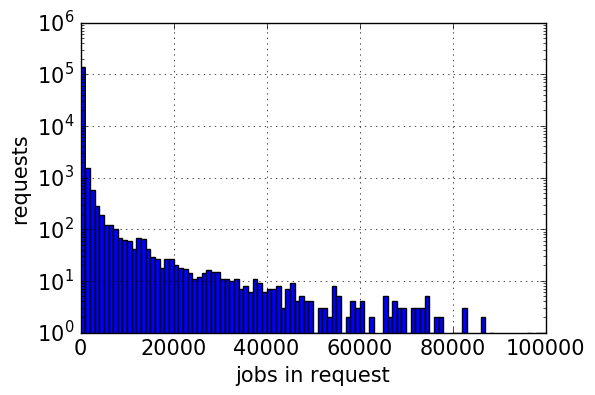

In [207]:
plt.rcParams.update({'font.size': 15})
grouped = df[df.type == 'production'].groupby(['task'], as_index=False)
a = grouped['njobs'].sum()
print np.mean(a['njobs'])
fig = a['njobs'].hist(bins=100, log=True, range=[0., 100000.])
plt.xlabel('jobs in request')
plt.ylabel('requests')

## Average number of events in request

12950.0


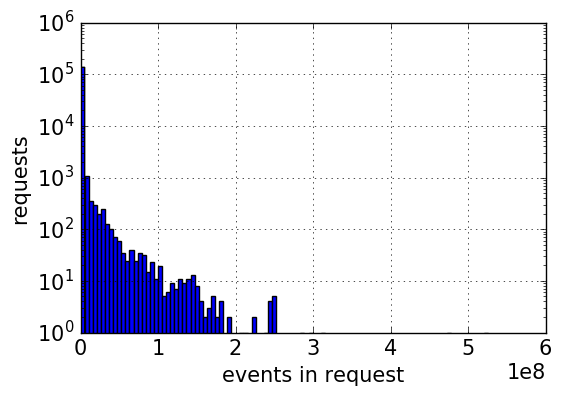

In [209]:
grouped = df[df.type == 'production'].groupby(['task'], as_index=False)
a = grouped['evts'].sum()
print np.median(a['evts'])
fig = a['evts'].hist(bins=100, log=True)
plt.xlabel('events in request')
plt.ylabel('requests')

## Average CPU efficiency of requests

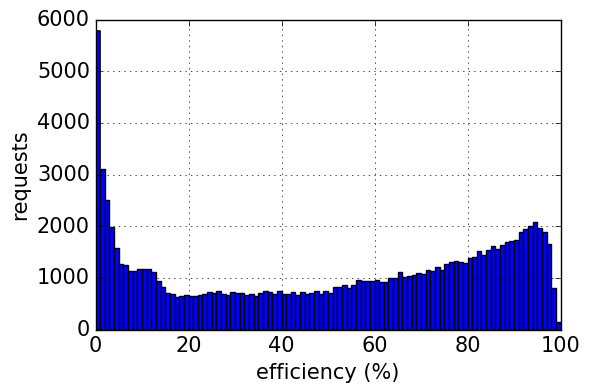

In [212]:
grouped = df[df.type == 'analysis'].groupby(['task'], as_index=False)
a = grouped['eff'].mean()
fig = a['eff'].hist(bins=100, log=False, range=(0, 100))   # NOT VERY CORRECT (arithmetic mean of efficiencies...)
plt.xlabel('efficiency (%)')
plt.ylabel('requests')

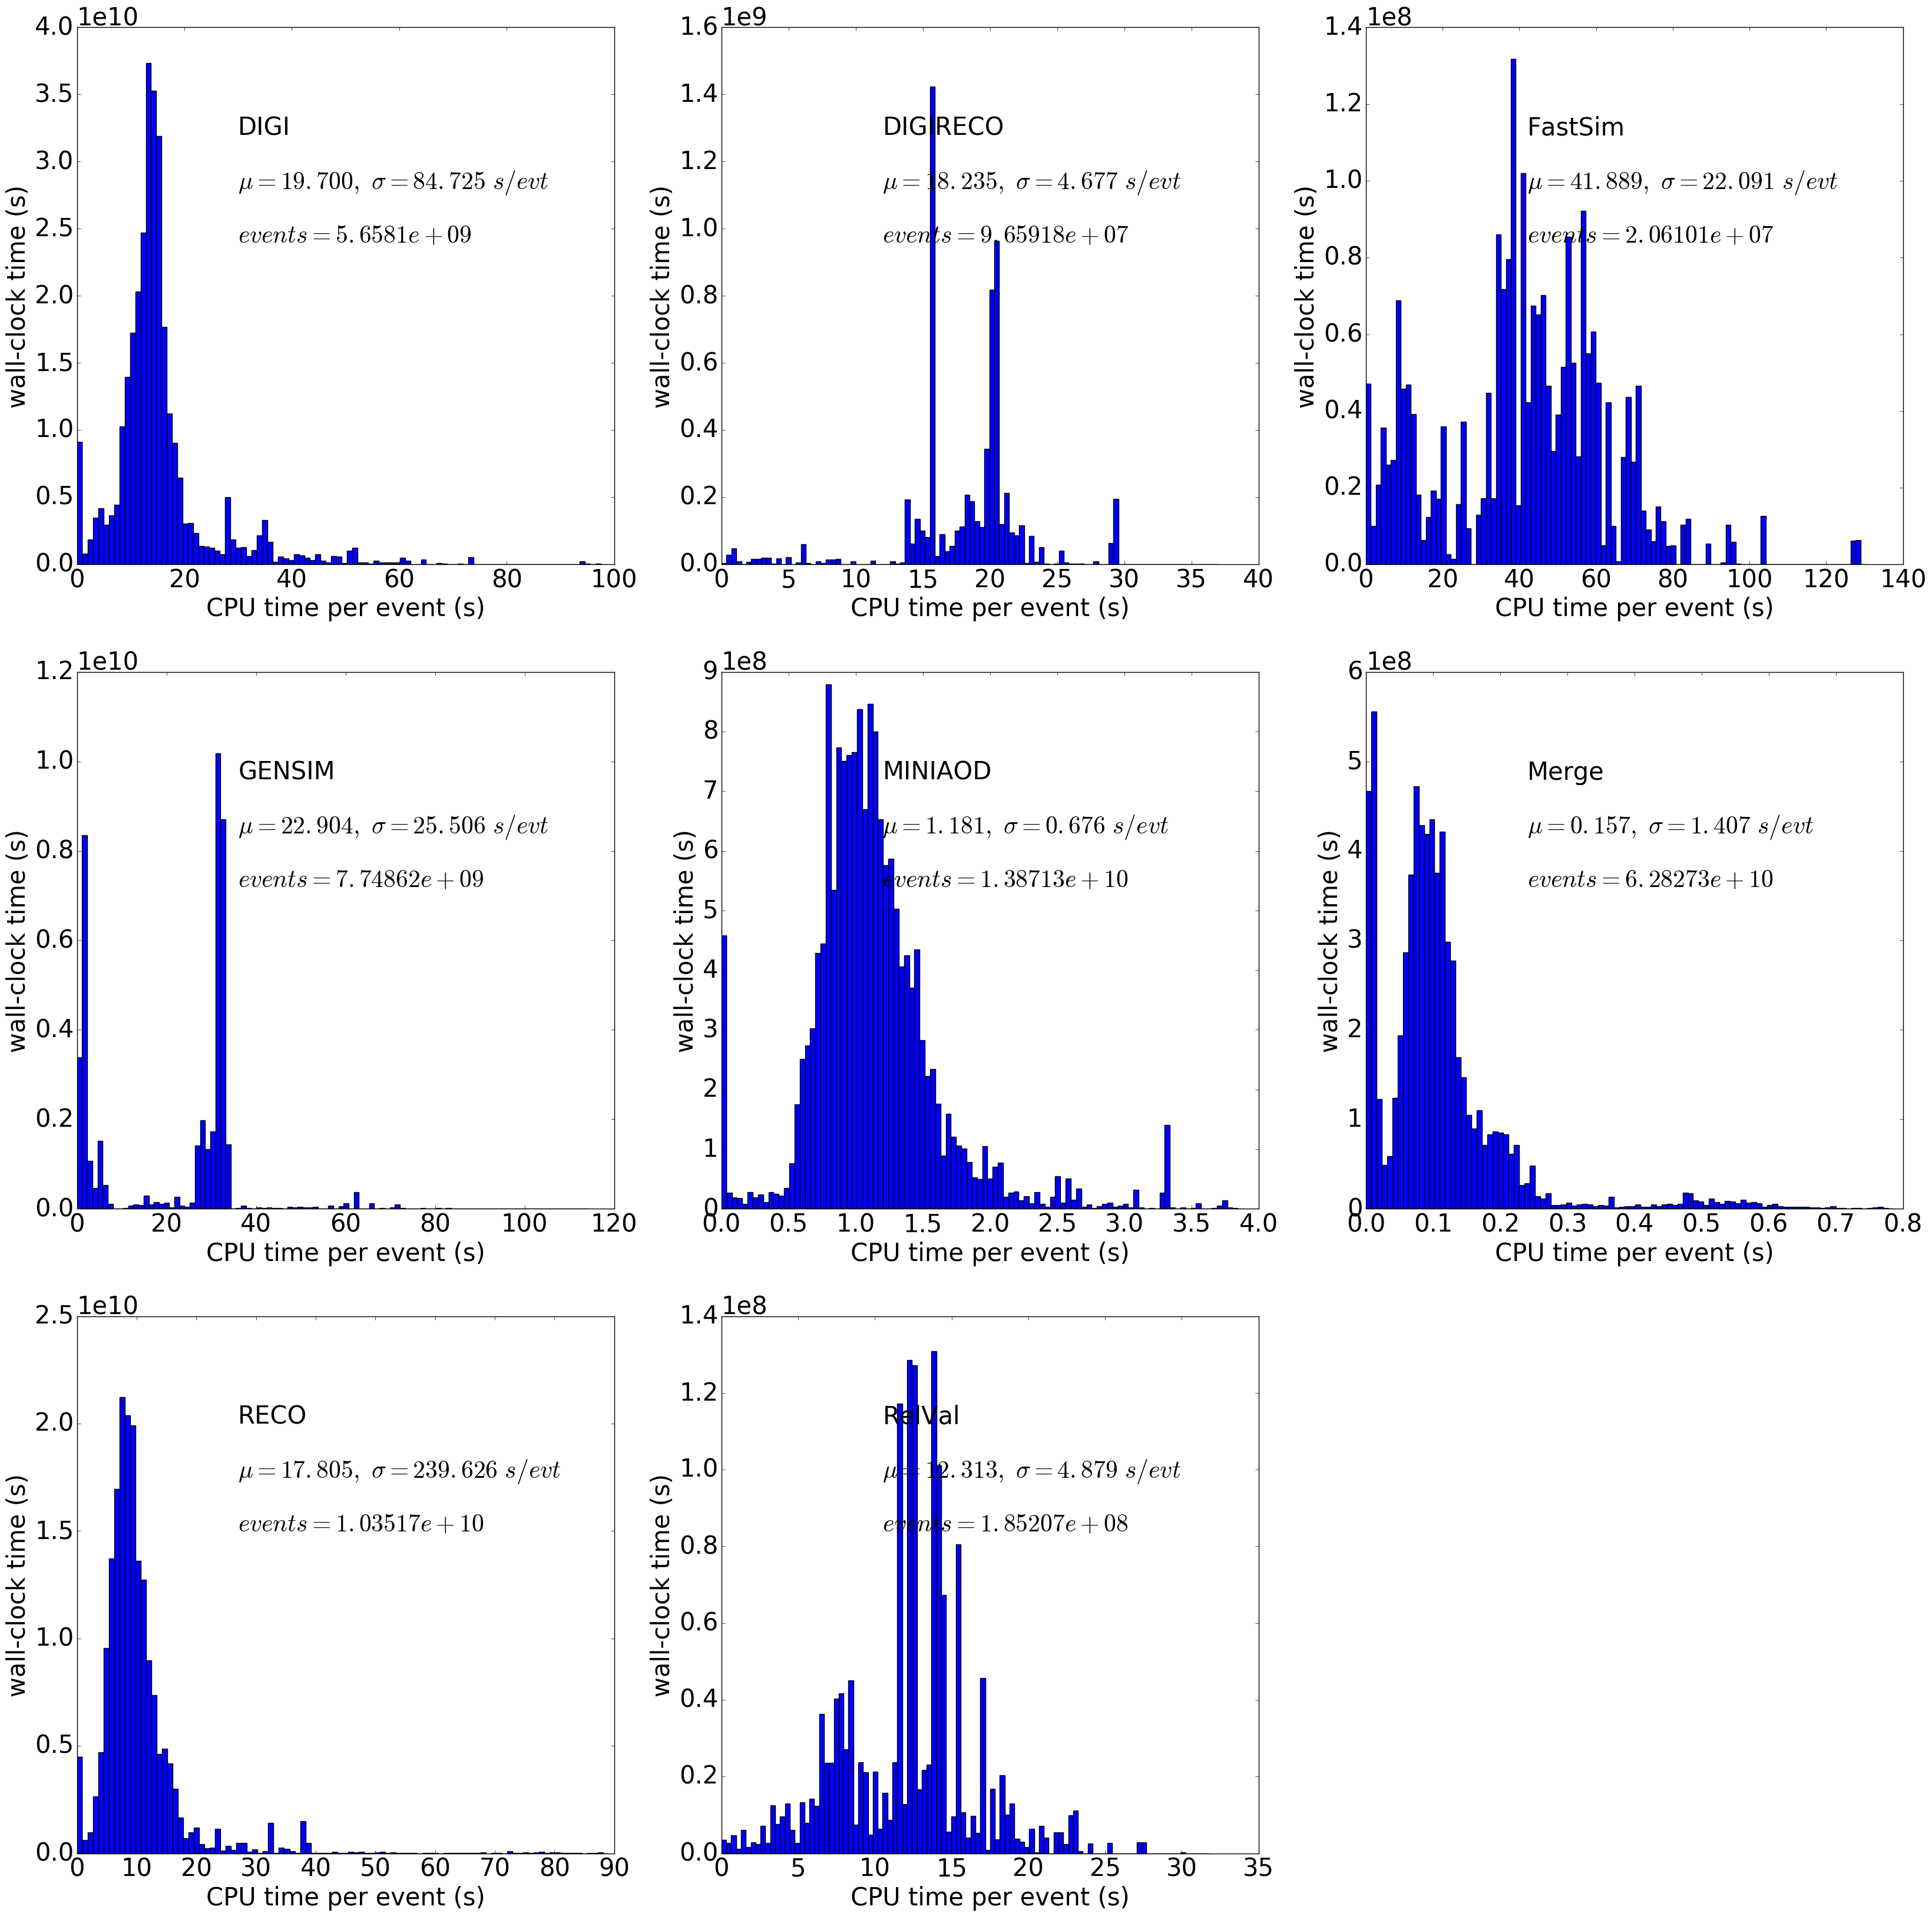

In [216]:
fig = plt.figure(figsize=(40,40))
plt.rcParams.update({'font.size': 30})
var = 'cpuevt_avg'
log_scale = False
wc_tot = df[df.type == 'production']['wc'].sum()
i = 1

grouped = df[df.type == 'production'].groupby(['jobtype'], as_index=False)

for (p), g in grouped:
    if g['wc'].sum() < 0.001 * wc_tot:
        continue
    mean = np.average(g[var], weights=g['wc'])   # average time weighted with no. of events
    std = math.sqrt(np.average((g[var] - mean)**2, weights=g['wc']))
    range = [0., mean + min(mean, std) * 4.]
    sp = plt.subplot(3, 3, i)
    plt.hist(g[var].tolist(), bins=100, range=range, weights=g['wc'].tolist(), log=log_scale)   # integral is total no. of events
    plt.xlabel('CPU time per event (s)')
    plt.ylabel('wall-clock time (s)')
    t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
    t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
    stats = r'$\mu=%.3f,\ \sigma=%.3f\ s/evt$' % (mean, std)
    stats2 = r'$\mathit{events}=%g$' % g['evts'].sum()
    if log_scale:
        plt.text(t_x(.3), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.8, p)
        plt.text(t_x(.3), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.7, stats)
        plt.text(t_x(.3), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.6, stats2)
    else:
        plt.text(t_x(.3), t_y(.8), p)
        plt.text(t_x(.3), t_y(.7), stats)
        plt.text(t_x(.3), t_y(.6), stats2)
    i += 1

In [ ]:
fig = plt.figure(figsize=(40,40))
plt.rcParams.update({'font.size': 30})
var = 'wallevt_avg'
log_scale = False
wc_tot = df[df.type == 'production']['wc'].sum()
i = 1

grouped = df[df.type == 'production'].groupby(['tasktype'], as_index=False)

for (p), g in grouped:
    if g['wc'].sum() < 0.006 * wc_tot:
        continue
    mean = np.average(g[var], weights=g['wc'])   # average time weighted with no. of events
    std = math.sqrt(np.average((g[var] - mean)**2, weights=g['wc']))
    range = [0., mean + min(mean, std) * 5.]
    sp = plt.subplot(3, 3, i)
    plt.hist(g[var].tolist(), bins=100, range=range, weights=g['wc'].tolist(), log=log_scale)   # integral is total no. of events
    plt.xlabel('wall-clock time per event (s)')
    plt.ylabel('wall-clock time (s)')
    t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
    t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
    stats = r'$\mu=%.3f,\ \sigma=%.3f\ s/evt$' % (mean, std)
    stats2 = r'$\mathit{events}=%g$' % g['evts'].sum()
    if log_scale:
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.8, p)
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.7, stats)
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.6, stats2)
    else:
        plt.text(t_x(.4), t_y(.8), p)
        plt.text(t_x(.4), t_y(.7), stats)
        plt.text(t_x(.4), t_y(.6), stats2)
    i += 1

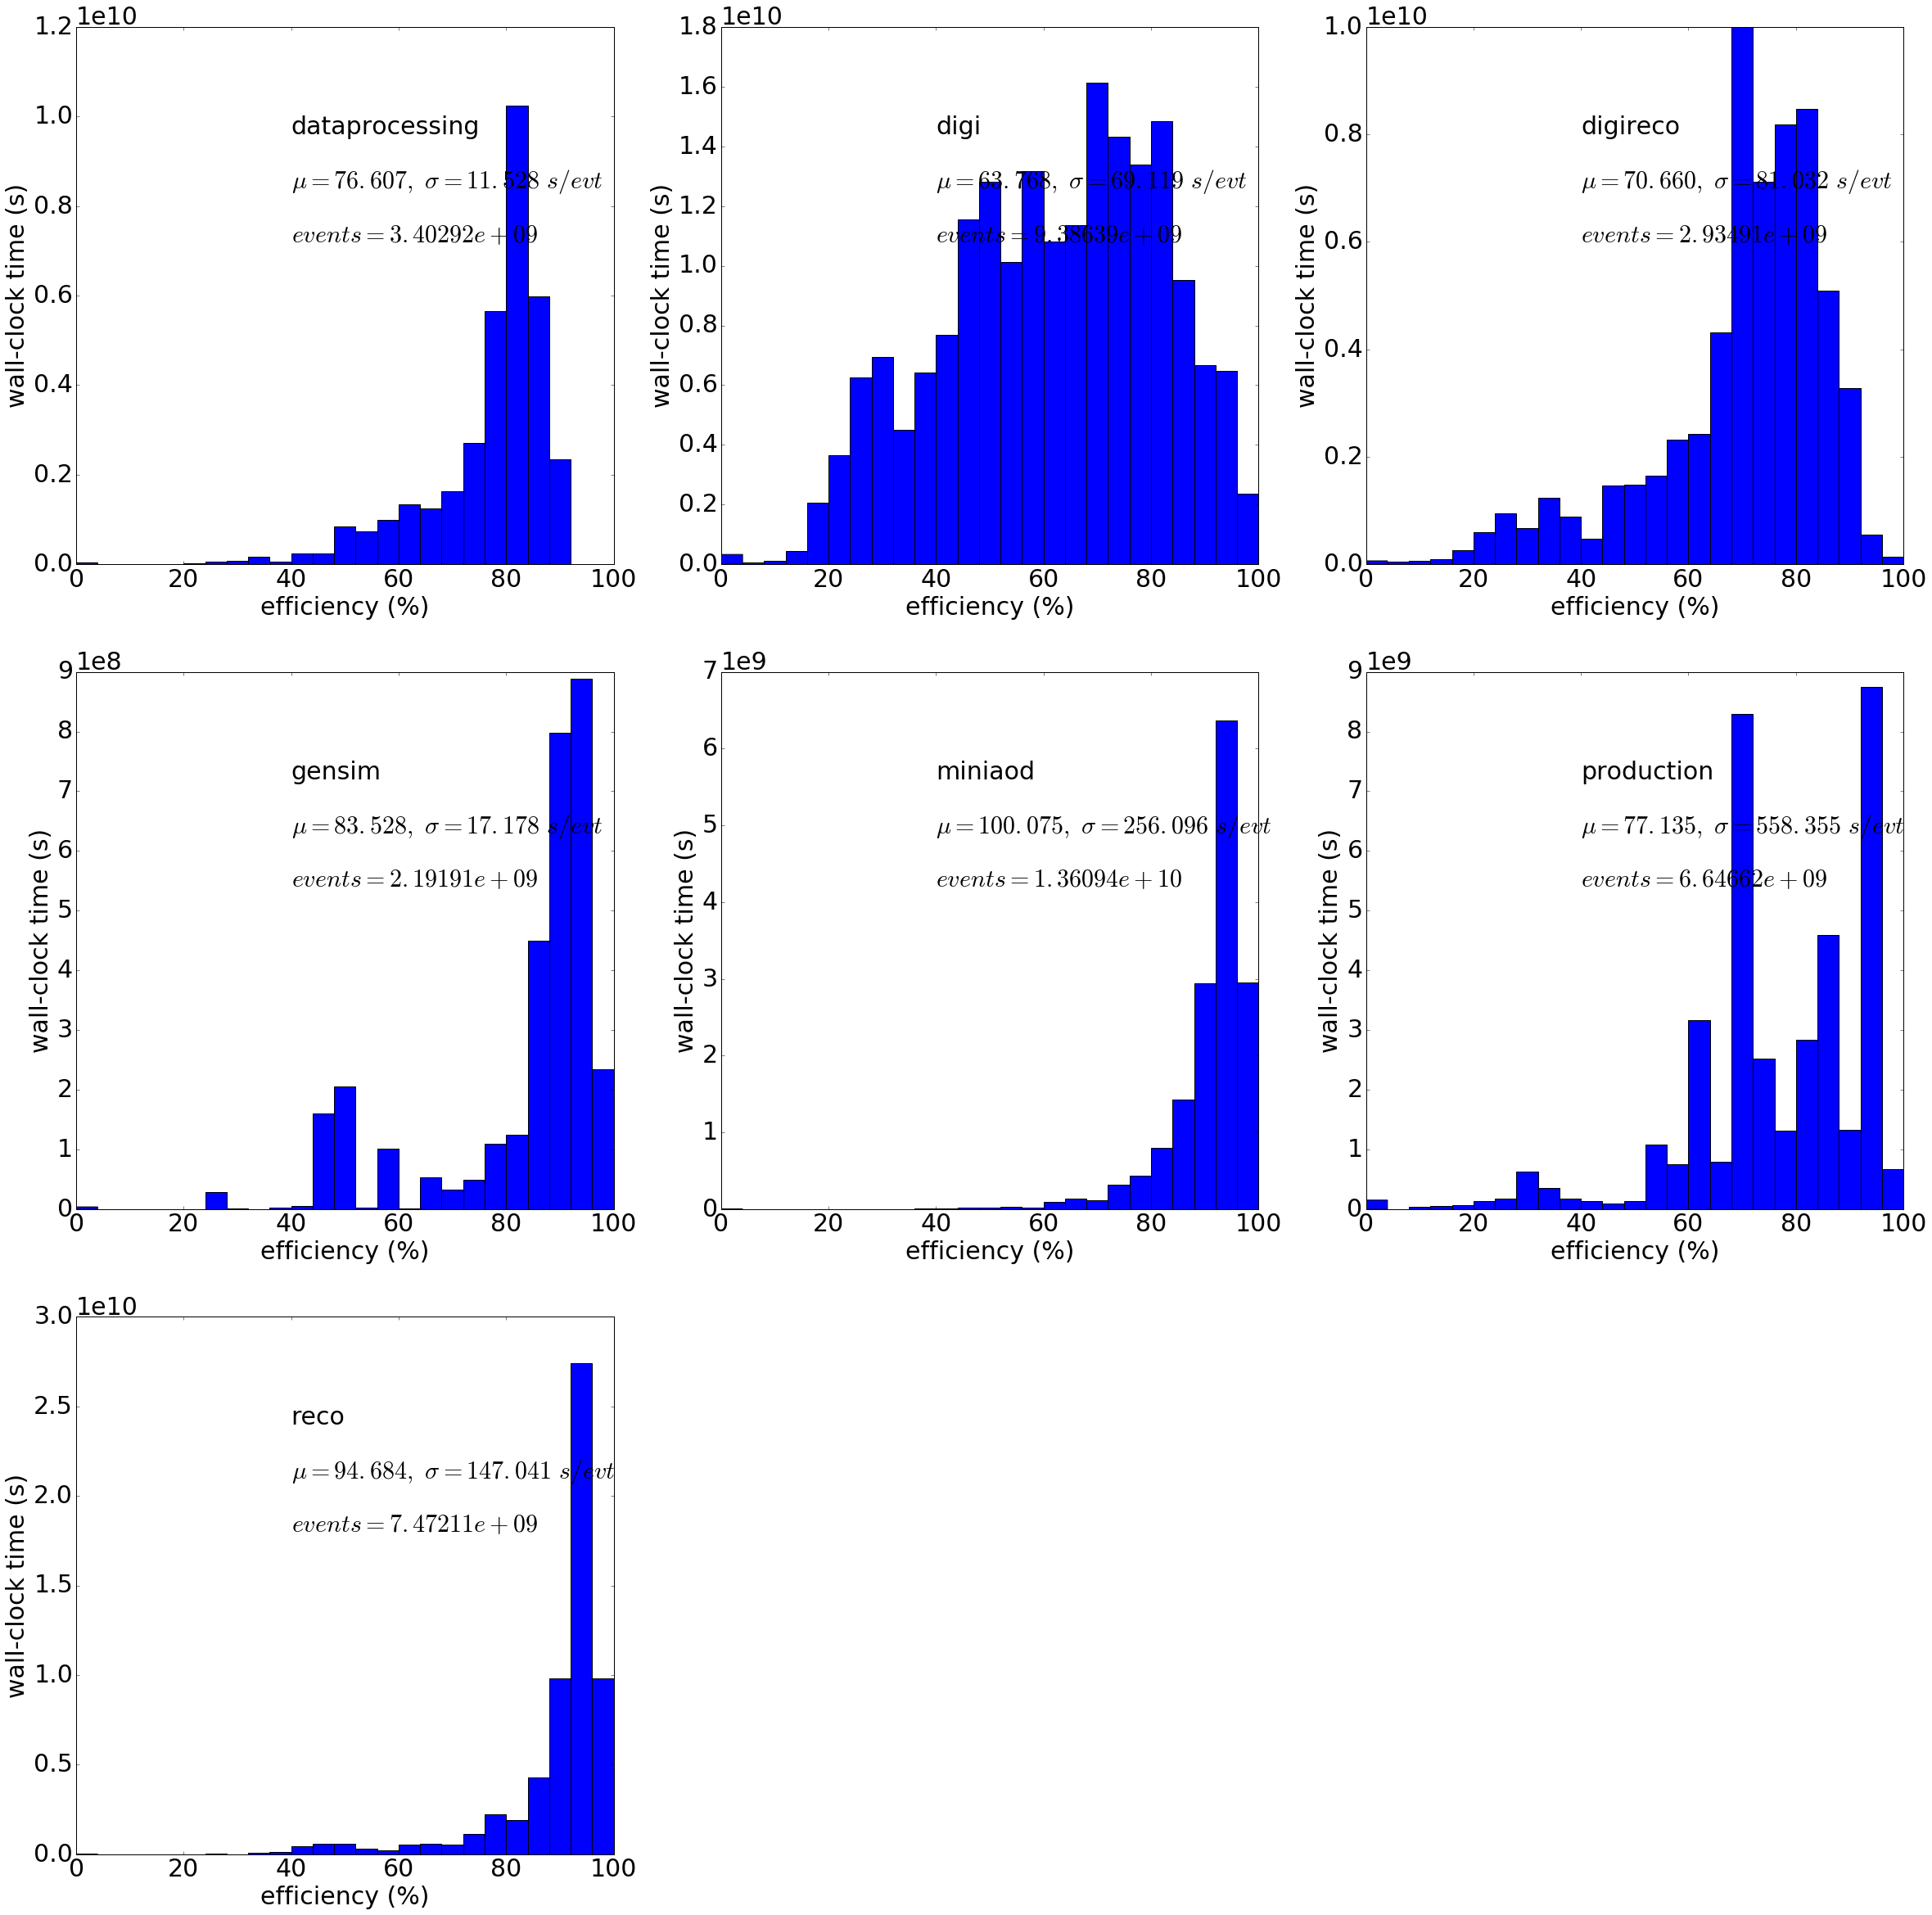

In [41]:
fig = plt.figure(figsize=(40,40))
plt.rcParams.update({'font.size': 30})
var = 'eff'
log_scale = False
wc_tot = df['wc'].sum()
i = 1

grouped = df.groupby(['processingtype'], as_index=False)

for (p), g in grouped:
    if g['wc'].sum() < 0.006 * wc_tot:
        continue
    mean = np.average(g[var], weights=g['wc'])   # average time weighted with no. of events
    std = math.sqrt(np.average((g[var] - mean)**2, weights=g['wc']))
    range = [0., 100.]
    sp = plt.subplot(3, 3, i)
    plt.hist(g[var].tolist(), bins=25, range=range, weights=g['wc'].tolist(), log=log_scale)   # integral is total no. of events
    plt.xlabel('efficiency (%)')
    plt.ylabel('wall-clock time (s)')
    t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
    t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
    stats = r'$\mu=%.3f,\ \sigma=%.3f\ s/evt$' % (mean, std)
    stats2 = r'$\mathit{events}=%g$' % g['evts'].sum()
    if log_scale:
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.8, p)
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.7, stats)
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.6, stats2)
    else:
        plt.text(t_x(.4), t_y(.8), p)
        plt.text(t_x(.4), t_y(.7), stats)
        plt.text(t_x(.4), t_y(.6), stats2)
    i += 1

In [38]:
ptype = 'miniaod'

# Find JEDI task with given parameters
tot_evts = dict()
grouped = df.groupby(['processingtype', 'request'], as_index=False)
for (p, j), g in grouped:
    if (p != ptype): continue
    tot_evts[j] = g['evts'].sum()

biggest_tasks = sorted(tot_evts, key=tot_evts.get, reverse=True)
a = biggest_tasks[:1]
random_task = np.random.choice(a, 1)
print random_task

['pdmvserv_sus-runiispring15miniaodv2-00479_00409_v0__160329_003600_9430']


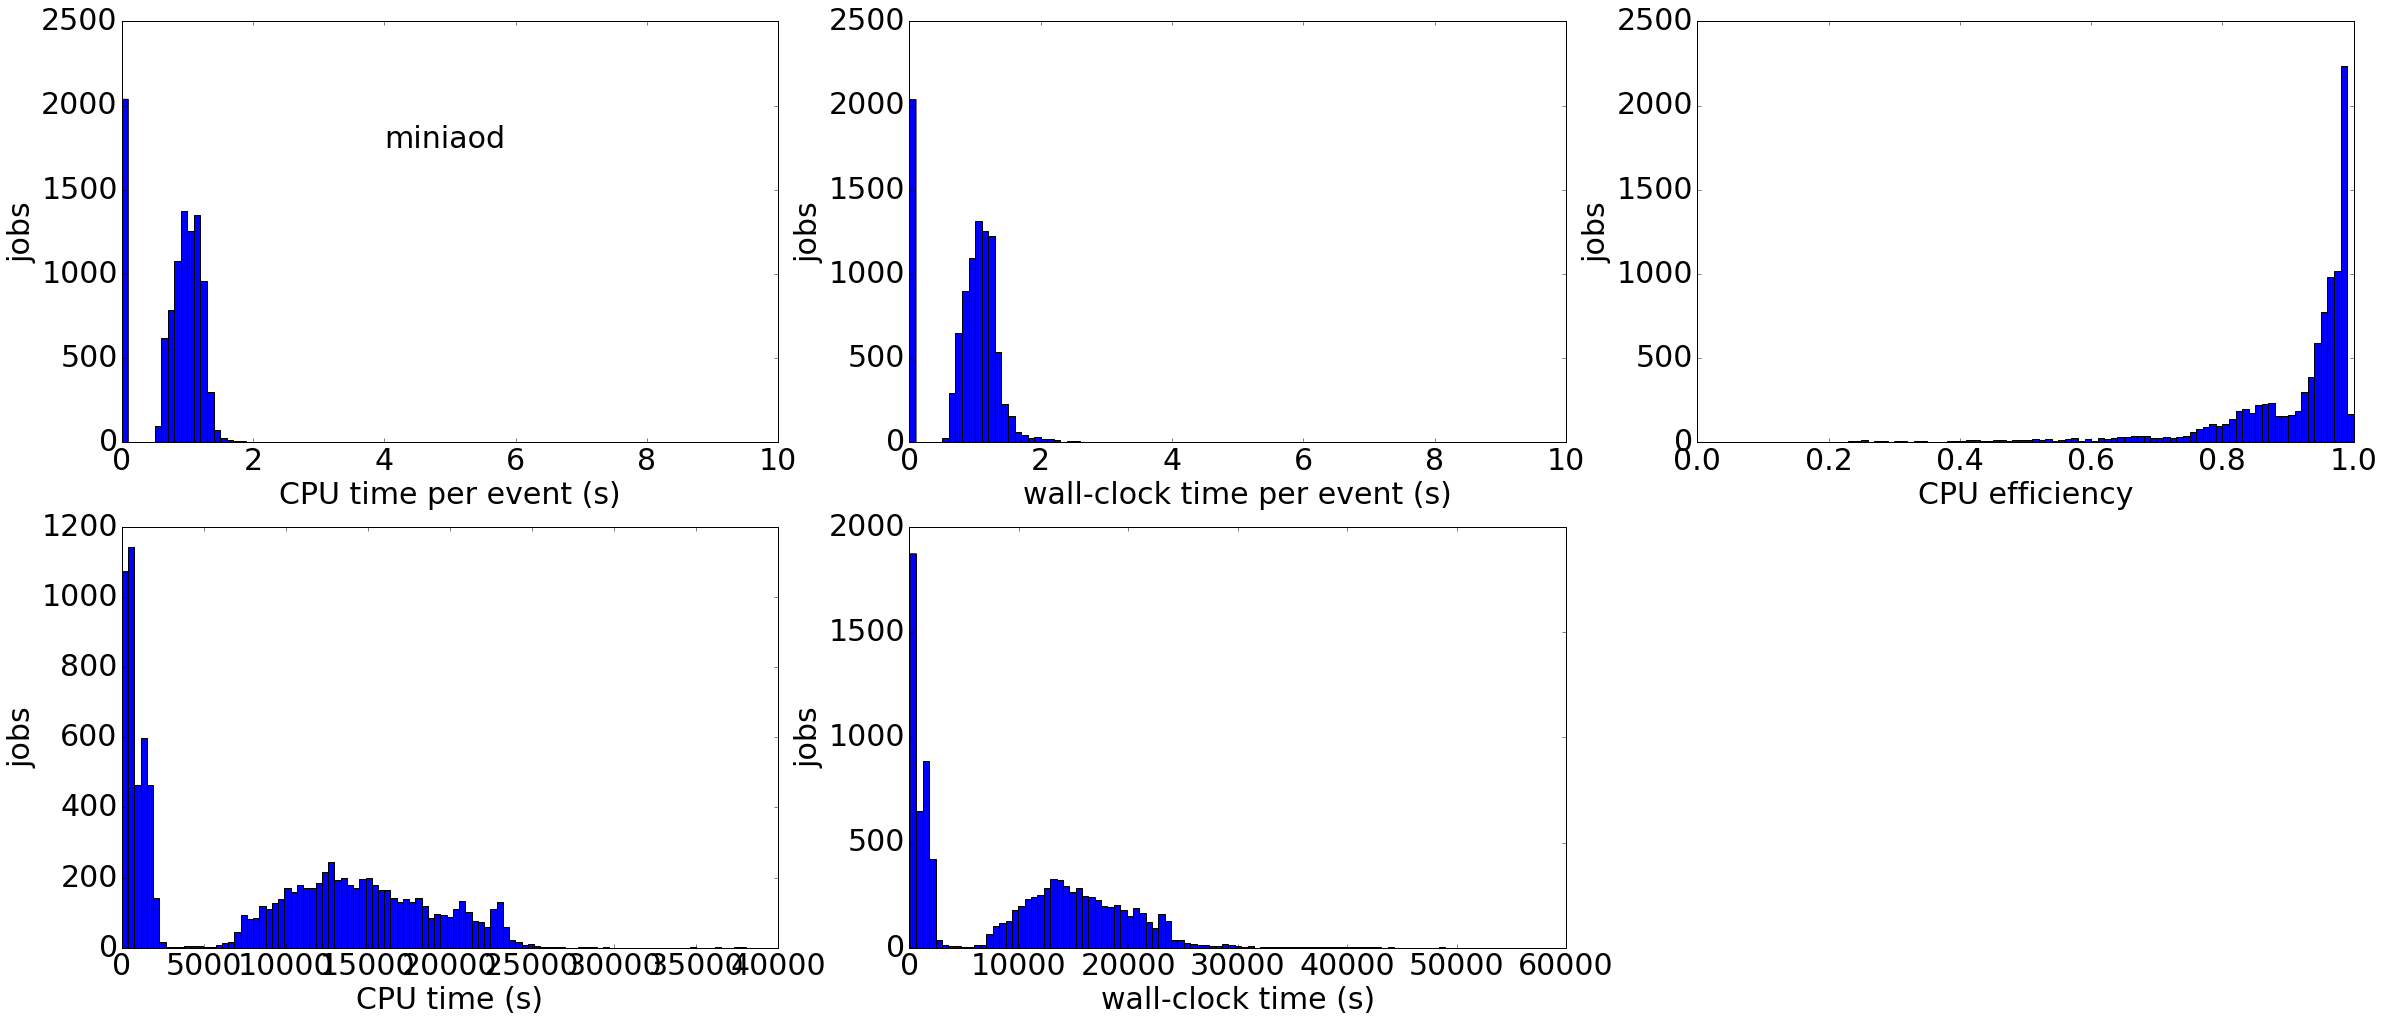

In [41]:
fig2 = plt.figure(figsize=(40,80))
plt.rcParams.update({'font.size': 30})
i = 1
for t in random_task:
    s = {
        "size": 10000,
        "_source": ["CpuTimeHr", "CoreHr", "RequestCpus", "KEvents", "CpuEff"],
        "query": {
            "filtered": {
                "filter": {
                    "bool": {
                        "must": [
                            { "match": { "WMAgent_RequestName": t}},
                            { "range": {"KEvents": {"ge": 0.0001}}},
                            { "range": {"CoreHr": {"gte": 0.0010}}},
                            { "match": {"Status": "completed"}}
                        ]
                    }
                }
            }
        }
    }
    res = es.search(index=ind, body=s, request_timeout=300)
    cputimes = list()
    wctimes = list()
    effs = list()
    cpus = list()
    wcs = list()
    for h in res['hits']['hits']:
        vars = h['_source']
        cpuevt = vars['CpuTimeHr'] / vars['KEvents'] * 3.6
        wcevt = vars['CoreHr'] / vars['KEvents'] * 3.6
        eff = vars['CpuEff'] / 100.
        cpu = vars['CpuTimeHr'] * 3600.
        wc = vars['CoreHr'] * 3600.
        cputimes.append(cpuevt)
        wctimes.append(wcevt)
        effs.append(eff)
        cpus.append(cpu)
        wcs.append(wc)
    sp = plt.subplot(9, 3, i)
    plt.hist(cputimes, bins=100, range=[0., 10.])
    plt.xlabel('CPU time per event (s)')
    plt.ylabel('jobs')
    t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
    t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
    plt.text(t_x(0.4), t_y(.7), ptype)
#    stats = r'$req=%s$' % (t)
#    plt.text(t_x(.4), t_y(.6), stats)
    sp = plt.subplot(9, 3, i+1)
    plt.hist(wctimes, bins=100, range=[0., 10.])
    plt.xlabel('wall-clock time per event (s)')
    plt.ylabel('jobs')
    sp = plt.subplot(9, 3, i+2)
    plt.hist(effs, bins=100, range=[0., 1.])
    plt.xlabel('CPU efficiency')
    plt.ylabel('jobs')
    sp = plt.subplot(9, 3, i+3)
    plt.hist(cpus, bins=100, range=None)
    plt.xlabel('CPU time (s)')
    plt.ylabel('jobs')
    sp = plt.subplot(9, 3, i+4)
    plt.hist(wcs, bins=100, range=None)
    plt.xlabel('wall-clock time (s)')
    plt.ylabel('jobs')
    i += 5